# Machine Learning for Classification

In [4]:
# !pip install -r "/content/drive/MyDrive/Ari Folders/Data_Ari/Data_Science/Digital Skola after Fazz/Corporate Training/Astra Honda Motor/For Ari/requirements_colab.txt"

In [5]:
# import library
import pandas as pd
import numpy as np
import os
import glob

# import visualization library
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# import machine learning model
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pickle

import sys
sys.path.append('/content/drive/MyDrive/Ari Folders/Data_Ari/Data_Science/Digital Skola after Fazz/Corporate Training/Astra Honda Motor/For Ari/Materials')
import collection_function as cus_viz

import warnings
warnings.filterwarnings('ignore')

## Data Preparation

In [6]:
# # Upload file from Google Drive

# from google.colab import files

# uploaded = files.upload()

In [7]:
# data = pd.read_csv("insurance.csv")

# display(data.info())
# data.head()

In [38]:
data = pd.read_csv("https://raw.githubusercontent.com/densaiko/data_science_learning/main/dataset/Human%20Capital.csv")
display(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  awards_won            54808 non-null  int64  
 11  avg_training_score    52248 non-null  float64
 12  is_promoted           54808 non-null  int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 5.4+ MB


None

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,0,49.0,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,60.0,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,50.0,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,50.0,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,73.0,0


In [42]:
# # Select desired columns
# data_new = data.drop(columns=['employee_id'])
# data_new = data_new[["department",	"region",	"education",	"gender",	"recruitment_channel"]]

# from google.colab import files
# data_new.to_csv('data_new.csv')
# files.download('data_new.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
# prompt: Pivot table to get number of employees in each gender from data

data.pivot_table(index='gender', values='employee_id', aggfunc='count')

,employee_id
gender,
f,16312
m,38496


## Exploratory Data Analysis

,is_promoted,employee_id
0,0,50140
1,1,4668


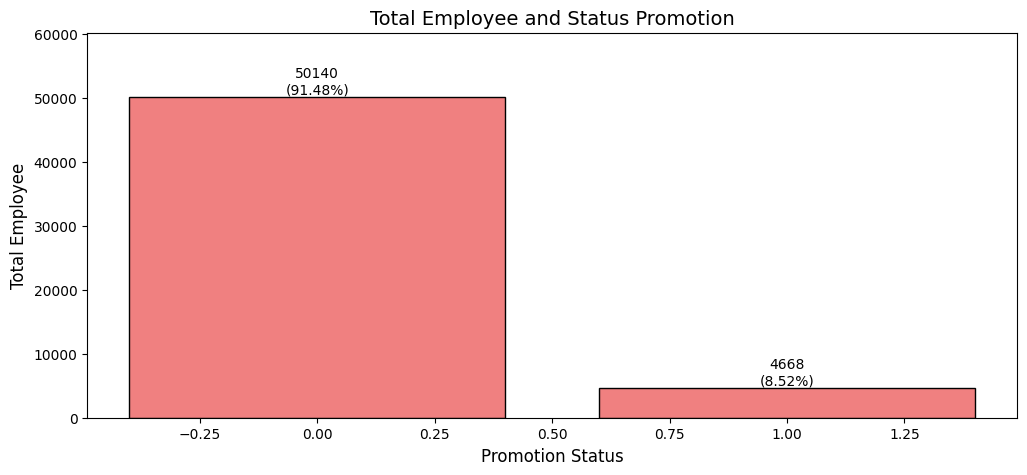

In [10]:
# Perbandingan karyawan dapat promosi dan tidak
pivot_promoted = cus_viz.simple_pivot(data=data, ind='is_promoted', val='employee_id', agg=pd.Series.nunique).sort_values(by='employee_id', ascending=False)
display(pivot_promoted)

# visualisasi
cus_viz.bar_chart(data=pivot_promoted, x_vals='is_promoted', y_vals='employee_id', title='Total Employee and Status Promotion',
                  xlabel='Promotion Status', ylabel='Total Employee', ymax=10000)

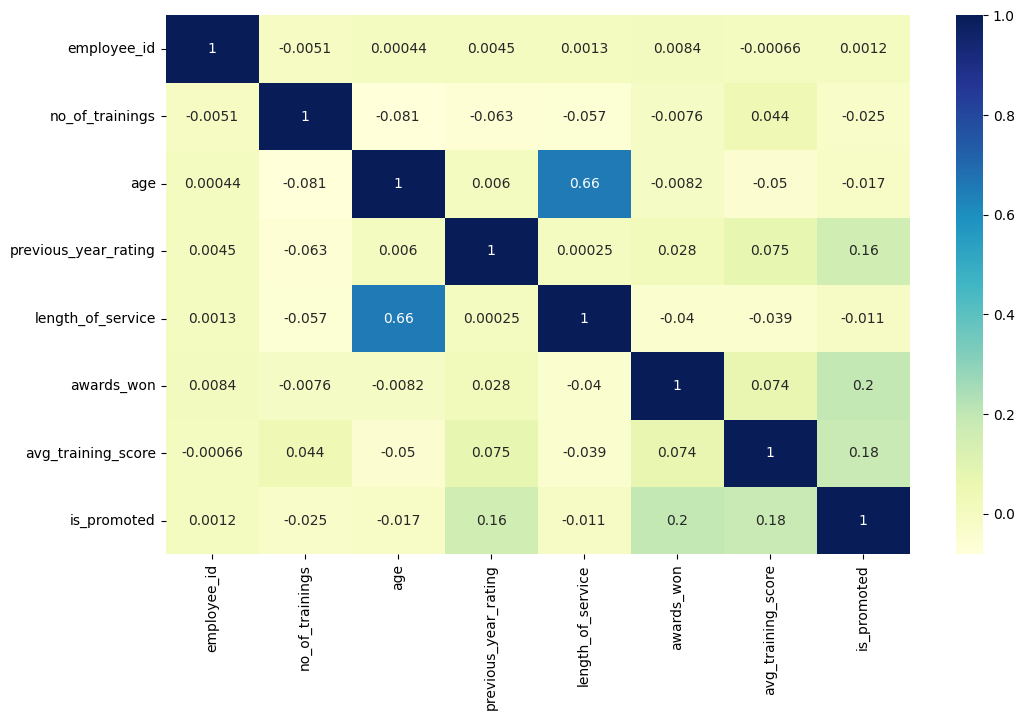

In [11]:
# Heatmap Correlation
cols = data.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(12,7))
sns.heatmap(data[cols].corr(), annot=True, cmap='YlGnBu')
plt.show()

## Data Pre-processing

In [12]:
# Drop missing values
data = data.dropna()

In [13]:
# Select desired columns
data_new = data.drop(columns=['employee_id'])

In [14]:
# get the categorical column
categorical_cols = data_new.select_dtypes(include='object').columns.tolist()
encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    encoded_col = f"{col}_encoded"
    data_new[encoded_col] = le.fit_transform(data_new[col])
    encoders[col] = le  # Save the encoder

data_new

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted,department_encoded,region_encoded,education_encoded,gender_encoded,recruitment_channel_encoded
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,0,49.0,0,7,31,2,0,2
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,60.0,0,4,14,0,1,0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,50.0,0,7,10,0,1,2
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,50.0,0,7,15,0,1,0
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,73.0,0,8,18,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54802,Sales & Marketing,region_14,Bachelor's,m,other,2,31,1.0,2,0,49.0,0,7,5,0,1,0
54803,Technology,region_14,Bachelor's,m,sourcing,1,48,3.0,17,0,78.0,0,8,5,0,1,2
54804,Operations,region_27,Master's & above,f,other,1,37,2.0,6,0,56.0,0,4,19,2,0,0
54805,Analytics,region_1,Bachelor's,m,other,1,27,5.0,3,0,79.0,0,0,0,0,1,0


In [15]:
def show_encoding_mappings(df, encoded_columns):
    for col in encoded_columns:
        original_col = col.replace('_encoded', '')
        if original_col in df.columns:
            print(f"\nMapping for '{original_col}' ➜ '{col}':")
            mapping_df = df[[original_col, col]].drop_duplicates().sort_values(col)
            print(mapping_df.to_string(index=False))

In [16]:
encoded_columns = ["department_encoded", "region_encoded", "education_encoded", "gender_encoded", "recruitment_channel_encoded"]

show_encoding_mappings(data_new, encoded_columns)



Mapping for 'department' ➜ 'department_encoded':
       department  department_encoded
        Analytics                   0
          Finance                   1
               HR                   2
            Legal                   3
       Operations                   4
      Procurement                   5
              R&D                   6
Sales & Marketing                   7
       Technology                   8

Mapping for 'region' ➜ 'region_encoded':
   region  region_encoded
 region_1               0
region_10               1
region_11               2
region_12               3
region_13               4
region_14               5
region_15               6
region_16               7
region_17               8
region_18               9
region_19              10
 region_2              11
region_20              12
region_21              13
region_22              14
region_23              15
region_24              16
region_25              17
region_26              18
region_2

In [17]:
# Data for Machine Learning
cols = ["department_encoded", "region_encoded", "education_encoded", "gender_encoded", "recruitment_channel_encoded", "no_of_trainings", 'age',
        "previous_year_rating", "length_of_service", "awards_won", "avg_training_score", "is_promoted"]

data_ml = data_new[cols]
data_ml.head()

,department_encoded,region_encoded,education_encoded,gender_encoded,recruitment_channel_encoded,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
0,7,31,2,0,2,1,35,5.0,8,0,49.0,0
1,4,14,0,1,0,1,30,5.0,4,0,60.0,0
2,7,10,0,1,2,1,34,3.0,7,0,50.0,0
3,7,15,0,1,0,2,39,1.0,10,0,50.0,0
4,8,18,0,1,0,1,45,3.0,2,0,73.0,0


In [18]:
# Separating dependent and independent variable
X = data_ml.drop(columns="is_promoted") #independent variable
y = data_ml["is_promoted"] #dependent variable

# Performing train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

## Modelling & Evalution

### Simple Model

In [19]:
# Logistic Regression Modelling
legReg = LogisticRegression()
legReg.fit(X_train, y_train)

# Evaluation
y_predict_train = legReg.predict(X_train)
y_predict_test = legReg.predict(X_test)

print("Model: Logistic Regression")
print("Training Accuracy: {:.2f}".format(accuracy_score(y_train, y_predict_train)))
print("Testing Accuracy: {:.2f}".format(accuracy_score(y_test, y_predict_test)))
print(classification_report(y_test, y_predict_test))

Model: Logistic Regression
Training Accuracy: 0.91
Testing Accuracy: 0.92
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      8504
           1       0.61      0.06      0.12       772

    accuracy                           0.92      9276
   macro avg       0.77      0.53      0.54      9276
weighted avg       0.90      0.92      0.89      9276



### Classification Model with Function

In [20]:
def classification_model(model, X_train, X_test, y_train, y_test):
  """
  This function is used to run multiple model
  """

  # Modelling
  legReg = model
  legReg.fit(X_train, y_train)

  # Evaluation
  y_predict_train = legReg.predict(X_train)
  y_predict_test = legReg.predict(X_test)

  print("Model: {}".format(model))
  print("Training Accuracy: {:.2f}".format(accuracy_score(y_train, y_predict_train)))
  print("Testing Accuracy: {:.2f}".format(accuracy_score(y_test, y_predict_test)))
  print(classification_report(y_test, y_predict_test))

In [21]:
classification_model(model=DecisionTreeClassifier(), X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

Model: DecisionTreeClassifier()
Training Accuracy: 1.00
Testing Accuracy: 0.88
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      8504
           1       0.32      0.41      0.36       772

    accuracy                           0.88      9276
   macro avg       0.63      0.66      0.64      9276
weighted avg       0.89      0.88      0.88      9276



In [22]:
classification_model(model=RandomForestClassifier(), X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

Model: RandomForestClassifier()
Training Accuracy: 1.00
Testing Accuracy: 0.94
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      8504
           1       0.85      0.27      0.41       772

    accuracy                           0.94      9276
   macro avg       0.89      0.63      0.69      9276
weighted avg       0.93      0.94      0.92      9276



In [23]:
classification_model(model=XGBClassifier(), X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Training Accuracy: 0.95
Testing Accuracy: 0.94
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      8504
           1       0.92      0.36      0.52       772

    accuracy            

## Hyperparamater Tuning

## Predict New Data

In [24]:
# modelling
lr = XGBClassifier()
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Copy X_test original
X_test_copy = X_test.copy()

# Insert the price prediction and price original column
X_test_copy['promoted_prediction'] = y_test_pred
X_test_copy['is_promoted'] = y_test

X_test_copy.head(10)

,department_encoded,region_encoded,education_encoded,gender_encoded,recruitment_channel_encoded,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,promoted_prediction,is_promoted
14193,7,14,2,1,2,1,31,5.0,3,0,47.0,0,0
48142,5,11,0,1,0,2,40,3.0,8,0,72.0,0,0
44565,7,29,0,1,2,1,29,1.0,5,0,49.0,0,0
48352,7,14,2,0,2,1,40,3.0,12,0,50.0,0,0
27900,4,14,0,1,0,3,37,5.0,8,0,63.0,0,1
48877,2,11,2,1,2,2,52,5.0,19,0,56.0,0,0
39814,5,12,0,1,0,1,28,5.0,2,0,75.0,0,1
14997,2,11,0,1,2,1,31,2.0,5,0,51.0,0,0
14697,2,11,0,1,2,1,29,5.0,6,0,51.0,0,0
234,0,11,0,1,2,2,54,3.0,9,0,86.0,0,0


In [25]:
# data baru yang belum ada price
new_data = pd.DataFrame([{
    'department': "Sales & Marketing",
    'region': "region_22",
    'education': "Bachelor's",
    'gender': "m",
    'recruitment_channel': "sourcing",
    'no_of_trainings': 2,
    'age': 30,
    'previous_year_rating': 5.0,
    'length_of_service': 4,
    'awards_won': 1,
    'avg_training_score': 10
}])

# Tampilkan data baru
new_data


,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score
0,Sales & Marketing,region_22,Bachelor's,m,sourcing,2,30,5.0,4,1,10


In [26]:
# Assuming data_new contains raw text like "mpv", "cruiser", etc.
categorical_cols = ["department",	"region",	"education",	"gender",	"recruitment_channel"]

for col in categorical_cols:
    encoded_col = f"{col}_encoded"
    le = encoders[col]  # Load saved encoder
    new_data[encoded_col] = le.transform(new_data[col])

new_data.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,department_encoded,region_encoded,education_encoded,gender_encoded,recruitment_channel_encoded
0,Sales & Marketing,region_22,Bachelor's,m,sourcing,2,30,5.0,4,1,10,7,14,0,1,2


In [27]:
X_test.columns

Index(['department_encoded', 'region_encoded', 'education_encoded',
       'gender_encoded', 'recruitment_channel_encoded', 'no_of_trainings',
       'age', 'previous_year_rating', 'length_of_service', 'awards_won',
       'avg_training_score'],
      dtype='object')

In [28]:
cols = ['department_encoded', 'region_encoded', 'education_encoded',
        'gender_encoded', 'recruitment_channel_encoded', 'no_of_trainings',
        'age', 'previous_year_rating', 'length_of_service', 'awards_won',
        'avg_training_score']

new_prediction = lr.predict(new_data[cols])

if new_prediction[0] == 1:
  print("Karyawan akan mendapatkan promosi")
else:
  print("Karyawan tidak akan mendapatkan promosi")

print("\nHasil Prediksi ML Model: {}".format(new_prediction[0]))

Karyawan tidak akan mendapatkan promosi

Hasil Prediksi ML Model: 0


## Preparation for Deployment

In [29]:
encoders

{'department': LabelEncoder(),
 'region': LabelEncoder(),
 'education': LabelEncoder(),
 'gender': LabelEncoder(),
 'recruitment_channel': LabelEncoder()}

In [30]:
# Simpan semua encoder ke dalam satu file
with open('label_encoders_classification.pkl', 'wb') as f:
    pickle.dump(encoders, f)

# Simpan model yang digunakan
with open('trained_model.pkl', 'wb') as f:
    pickle.dump(lr, f)

In [31]:
# data baru
data_baru = pd.DataFrame([{
          "department": "Procurement",
          "region": "region_34",
          "education": "Master's & above",
          "gender": "m",
          "recruitment_channel": "sourcing",
          "no_of_trainings": 1,
          "age": 37,
          "previous_year_rating": 5.0,
          "length_of_service": 3,
          "awards_won": 1,
          "avg_training_score": 92
}])

In [32]:
# Load encoder dari file
with open('label_encoders_classification.pkl', 'rb') as f:
    loaded_encoders = pickle.load(f)

# Transformasi data baru
for col in data_baru.columns:
    if col in loaded_encoders:
        le = loaded_encoders[col]
        data_baru[col + '_encoded'] = le.transform(data_baru[col])

data_baru

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,department_encoded,region_encoded,education_encoded,gender_encoded,recruitment_channel_encoded
0,Procurement,region_34,Master's & above,m,sourcing,1,37,5.0,3,1,92,5,27,2,1,2


In [33]:
# Load Model dari file
with open('trained_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Predict the data
cols = ['department_encoded', 'region_encoded', 'education_encoded',
        'gender_encoded', 'recruitment_channel_encoded', 'no_of_trainings',
        'age', 'previous_year_rating', 'length_of_service', 'awards_won',
        'avg_training_score']

new_prediction = model.predict(data_baru[cols])

if new_prediction[0] == 1:
  print("Karyawan akan mendapatkan promosi")
else:
  print("Karyawan tidak akan mendapatkan promosi")

print("\nHasil Prediksi ML Model: {}".format(new_prediction[0]))

Karyawan akan mendapatkan promosi

Hasil Prediksi ML Model: 1


## Model Deployment

In [34]:
# !pip install pyngrok

In [35]:
# !pip install flask_ngrok

In [36]:
!ngrok authtoken 2QXqc8gX2jQDew20AIB8lpfgMZn_5tjMZ7PuHAYTzRM9xLaeL

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [37]:
from flask import Flask, jsonify, request
from pyngrok import ngrok
import pandas as pd
import numpy as np
import pickle

# Inisialisasi app
app = Flask(__name__)

# Load model dan preprocessor
with open('trained_model.pkl', 'rb') as f:
    model = pickle.load(f)

with open('label_encoders_classification.pkl', 'rb') as f:
    encoders = pickle.load(f)

# Categorical columns & numeric
categorical_cols = ['department', 'region', 'education', 'gender', 'recruitment_channel']
numeric_cols = ['no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'awards_won','avg_training_score']

# Route prediksi
@app.route("/predict", methods=["POST"])
def predict():
    try:
        # Ambil input JSON dari user
        data = request.get_json()

        # Validasi input
        required_fields = categorical_cols + numeric_cols
        missing = [col for col in required_fields if col not in data]
        if missing:
            return jsonify({"status": "error", "message": f"Missing fields: {missing}"}), 400

        # Format ke DataFrame (harap input sesuai urutan dan kolom yang dipakai)
        df = pd.DataFrame([data])  # Assumes all fields are included

        # Encode categorical
        for col in categorical_cols:
            le = encoders[col]
            df[f"{col}_encoded"] = le.transform(df[col])

        # Gabungkan fitur
        final_features = [f"{col}_encoded" for col in categorical_cols] + numeric_cols
        input_data = df[final_features]

        # Prediksi
        prediction = model.predict(input_data)

        return jsonify({"status": "ok", "prediction": float(prediction[0])})

    except Exception as e:
        return jsonify({"status": "error", "message": str(e)}), 500

# Expose port 5000 with ngrok
public_url = ngrok.connect(5000)
print("Public URL:", public_url)

# Run the app
app.run(port=5000)

Public URL: NgrokTunnel: "https://0108-34-83-250-91.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [06/Jul/2025 01:43:25] "POST /predict HTTP/1.1" 500 -
INFO:werkzeug:127.0.0.1 - - [06/Jul/2025 01:44:41] "POST /predict HTTP/1.1" 200 -


### Deployment in Hugging Face

In [ ]:
from flask import Flask, jsonify, request
import pandas as pd
import numpy as np
import pickle

# Inisialisasi app
app = Flask(__name__)

# Load model dan preprocessor
with open('trained_model.pkl', 'rb') as f:
    model = pickle.load(f)

with open('label_encoders_classification.pkl', 'rb') as f:
    encoders = pickle.load(f)

# Categorical columns & numeric
categorical_cols = ['department', 'region', 'education', 'gender', 'recruitment_channel']
numeric_cols = ['no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'awards_won','avg_training_score']

# Route prediksi
@app.route("/predict", methods=["POST"])
def predict():
    try:
        # Ambil input JSON dari user
        data = request.get_json()

        # Validasi input
        required_fields = categorical_cols + numeric_cols
        missing = [col for col in required_fields if col not in data]
        if missing:
            return jsonify({"status": "error", "message": f"Missing fields: {missing}"}), 400

        # Format ke DataFrame (harap input sesuai urutan dan kolom yang dipakai)
        df = pd.DataFrame([data])  # Assumes all fields are included

        # Encode categorical
        for col in categorical_cols:
            le = encoders[col]
            df[f"{col}_encoded"] = le.transform(df[col])

        # Gabungkan fitur
        final_features = [f"{col}_encoded" for col in categorical_cols] + numeric_cols
        input_data = df[final_features]

        # Prediksi
        prediction = model.predict(input_data)

        return jsonify({"status": "ok", "prediction": float(prediction[0])})

    except Exception as e:
        return jsonify({"status": "error", "message": str(e)}), 500

if __name__ == "__main__":
    app.run(host="0.0.0.0", port=7860)

In [43]:
!pip show xgboost
!pip show scikit-learn

Name: xgboost
Version: 2.1.4
Summary: XGBoost Python Package
Home-page: 
Author: 
Author-email: Hyunsu Cho <chohyu01@cs.washington.edu>, Jiaming Yuan <jm.yuan@outlook.com>
License: Apache-2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: numpy, nvidia-nccl-cu12, scipy
Required-by: 
Name: scikit-learn
Version: 1.6.1
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: BSD 3-Clause License

 Copyright (c) 2007-2024 The scikit-learn developers.
 All rights reserved.

 Redistribution and use in source and binary forms, with or without
 modification, are permitted provided that the following conditions are met:

 * Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

 * Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation